# **MNIST Handwritten Digit Recognition with Neural Networks**

In this notebook, we propose a simple **Neural Network (NN)** architecture to recognize hand-written digits. We use the **MNIST dataset**, consisting of **70,000 images**, split into **60,000 for training** and **10,000 for validation**.

## **Project Goals**
The aim of this project is two-fold:
1. To emphasize the importance of **hyperparameter tuning** and **regularization** in NNs, using a **fully connected neural network (FCNN)** as a starting point.
2. To demonstrate the effectiveness of **Convolutional Neural Networks (CNNs)** for image recognition, which significantly outperform simpler architectures for this task.

## **Baseline FCNN Model**
We begin with a **benchmark FCNN architecture**, inspired by standard literature:
- **One hidden layer** with **128 nodes**
- **ReLU** activation for the hidden layer
- **Softmax** activation in the output layer (multi-class classification)
- **Cross-entropy loss**, the standard for non-binary classification
- **Adam optimizer** with default **learning rate = 0.001**
- **Mini-batch size = 32**

We compute both **loss** and **accuracy** on the training and validation sets to assess the model's performance.

## **Hyperparameter Search**
Next, we perform a **grid search** over the following hyperparameters:
- **Learning rates**: `0.0001`, `0.001`, `0.01`
- **Batch sizes**: `32`, `64`, `128`
- **Epochs**: `10`, `20`, `50`
- **Hidden units**: `64`, `128`, `256`
- **Activation functions**: `relu`, `tanh`
- **Optimizers**: `adam`, `sgd`, `rmsprop`

This results in **486 combinations**. We train and evaluate each combination, selecting the **top 5 performing models** based on validation accuracy. We then introduce **regularization** techniques to reduce **overfitting**, and compare their impact.

We intentionally opt for a **grid search** rather than a randomized search to better **visualize the relationship** between hyperparameters and model performance, making this a **pedagogical introduction** to hyperparameter optimization.

## **CNN Architecture**
Finally, we apply a **Convolutional Neural Network (CNN)** to the same classification problem. We:
- Start with a **baseline CNN** model
- Perform a **randomized hyperparameter search** from the outset
- **Compare** the performance of the CNN to the FCNN

This approach highlights the **superiority of CNNs** for image-based tasks and reinforces the importance of **architectural choices** in deep learning.

In [6]:
#import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt
import shutil
import itertools
import random
import os
import time

In [3]:
# Load MNIST dataset from tf and reshape


# Set all relevant seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)  # Ensures reproducible hashing
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Print dataset statistics
print(f"Number of training images: {train_images.shape[0]}")
print(f"Image dimensions: {train_images.shape[1]}x{train_images.shape[2]}")
print(f"First label: {train_labels[0]} \n ")

# Normalize the image data RGB
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Print shape of train and test images, before and after reshaping
print(f"Dimension of array of training images: {train_images.shape}")
print(f"Dimension of array of training labels: {train_labels.shape}")
print(f"So, our training set has {train_images.shape[0]} examples, with {train_images.shape[1]}x{train_images.shape[2]} pixels per example")
print(f"Flattening out the image from a {train_images.shape[1]}x{train_images.shape[2]} array to a {train_images.shape[1]*train_images.shape[2]}-dimensional vector")


# Flatten each 28x28 image into a vector of size 784 (28*28)
x_train = train_images.reshape(-1, train_images.shape[1] * train_images.shape[2])
x_test = test_images.reshape(-1, test_images.shape[1] * test_images.shape[2])

y_train = train_labels
y_test = test_labels


# Print the new shape to verify
print(f"\nFlattened training images shape: {x_train.shape}")
print(f"Flattened test images shape: {x_test.shape}")

print(f"\nTraining images labels shape: {y_train.shape}")
print(f"Test images labels shape: {y_test.shape}")



Number of training images: 60000
Image dimensions: 28x28
First label: 5 
 
Dimension of array of training images: (60000, 28, 28)
Dimension of array of training labels: (60000,)
So, our training set has 60000 examples, with 28x28 pixels per example
Flattening out the image from a 28x28 array to a 784-dimensional vector

Flattened training images shape: (60000, 784)
Flattened test images shape: (10000, 784)

Training images labels shape: (60000,)
Test images labels shape: (10000,)


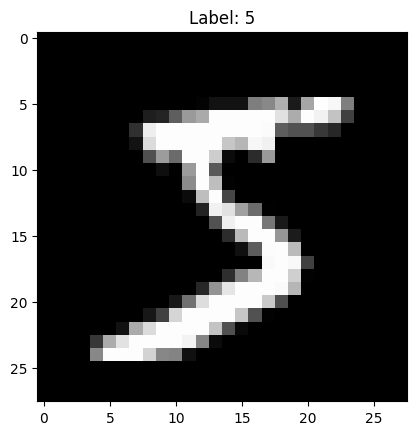

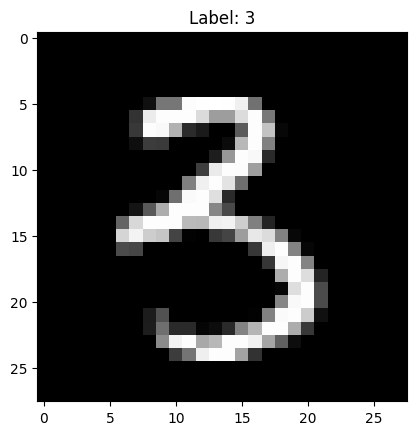

In [3]:
# Test plotting  loaded images
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()


plt.imshow(test_images[5000], cmap='gray')
plt.title(f"Label: {test_labels[5000]}")
plt.show()

As previously stated, we begin with a **benchmark neural network** with the following configuration:

- **One hidden layer** with **128 nodes** and a **ReLU activation function**
- **Output layer** with **10 nodes**, using a **softmax activation function** and **cross-entropy loss function**
- **Adam optimizer** with a **learning rate of 0.001** (default)
- **Mini-batch size** of **32** (default)
- **10 training epochs**

This architecture serves as a simple and effective starting point for handwritten digit recognition on the MNIST dataset.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8793 - loss: 0.4313 - val_accuracy: 0.9599 - val_loss: 0.1341
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9655 - loss: 0.1210 - val_accuracy: 0.9682 - val_loss: 0.1012
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9781 - loss: 0.0778 - val_accuracy: 0.9738 - val_loss: 0.0879
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9837 - loss: 0.0558 - val_accuracy: 0.9755 - val_loss: 0.0796
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9886 - loss: 0.0405 - val_accuracy: 0.9763 - val_loss: 0.0795
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9921 - loss: 0.0299 - val_accuracy: 0.9776 - val_loss: 0.0809
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9947 - loss: 0.0222 - val_accuracy: 0.9767 - val_loss: 0.0814
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9956 - loss: 0.01

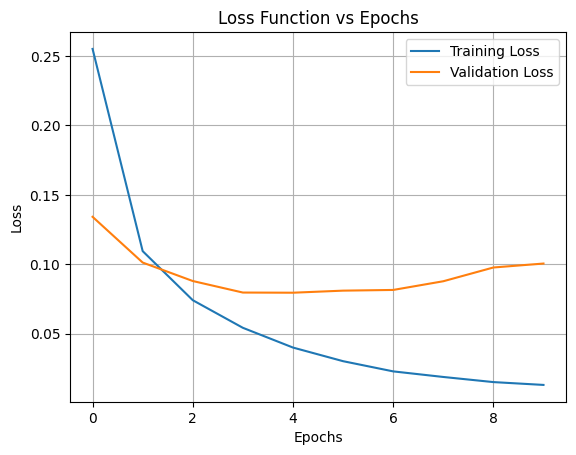

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9703 - loss: 0.1172     
Final training accuracy: 0.9965
Final dev accuracy: 0.9751

Final training error: 0.3533303737640381 %
Final dev error: 2.490001916885376 %


In [6]:
# Benchmark Neural Network (without regularization)


# Number of nodes in hidden and output layers
n1 = 128
nout = 10

model = models.Sequential([
    layers.Dense(n1, activation='relu', input_shape=(28*28,)),
    layers.Dense(nout, activation='softmax')
])


model.summary()


# Compile the model with ADAM
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model and save the training history
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Evaluate the model
model.evaluate(x_test, y_test)

training_error = (1 - history.history['accuracy'][-1])
dev_error = (1 - history.history['val_accuracy'][-1])

print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")

print(f"\nFinal training error: {training_error*100} %")
print(f"Final dev error: {dev_error*100} %")


We find the following performance metrics for the **baseline neural network**:

- **Final training error**: **0.31%**
- **Final validation (dev) error**: **2.33%**
- **Variance**: **2.02%**

This variance can be anticipated by examining the **loss curves**:
- The **training loss** decreases steadily over epochs.
- The **validation loss** plateaus after approximately **4 epochs**, suggesting the onset of **overfitting**.

We will address this issue later using **regularization techniques**.

---

We now explore the model more thoroughly by performing a **systematic grid search** over various hyperparameters.  
*Note: this process may take some time to run.*

In [6]:
# Hyperparameter grid
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = [10, 20, 50]
hidden_units = [64, 128, 256]
activations = ['relu', 'tanh']
optimizers = ['adam', 'sgd', 'rmsprop']


# Function to create and compile model
def create_model(learning_rate, batch_size, hidden_units, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# List to store results
results = []
best_val_accuracy = 0  # Track best validation accuracy


# Start the timer before training
start_time = time.time()

# Grid search
for lr, batch, epoch, units, activation, optimizer in itertools.product(
    learning_rates, batch_sizes, epochs, hidden_units, activations, optimizers):
    
    print(f"Training with lr={lr}, batch_size={batch}, epochs={epoch}, units={units}, activation={activation}, optimizer={optimizer}")
    
    model = create_model(lr, batch, units, activation, optimizer)
    
    # Train the model
    history = model.fit(x_train, y_train, 
                        epochs=epoch, 
                        batch_size=batch, 
                        validation_data=(x_test, y_test), 
                        verbose=0)
    
    # Evaluate model performance
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Save best model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model.save("best_mnist_model.h5")  # Save best model
        print(f"New best model found! Validation accuracy: {val_accuracy:.4f} (Saved)\n")
    
    # Store results
    results.append({
        'learning_rate': lr,
        'batch_size': batch,
        'epochs': epoch,
        'hidden_units': units,
        'activation': activation,
        'optimizer': optimizer,
        'val_accuracy': val_accuracy,
        'dev_error': 1 - val_accuracy
    })


# Stop the timer after training
end_time = time.time()

# Sort results by validation accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Print the top 5 results
print("\nTop 5 hyperparameter choices:")
for i, result in enumerate(sorted_results[:5]):
    print(f"\nRank {i+1}:")
    print(f"Learning rate: {result['learning_rate']}")
    print(f"Batch size: {result['batch_size']}")
    print(f"Epochs: {result['epochs']}")
    print(f"Hidden units: {result['hidden_units']}")
    print(f"Activation: {result['activation']}")
    print(f"Optimizer: {result['optimizer']}")
    print(f"Validation accuracy: {result['val_accuracy']:.4f}")
    print(f"Dev error: {result['dev_error'] * 100:.2f}%")


# Compute elapsed time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")


Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=adam


New best model found! Validation accuracy: 0.9740 (Saved)

Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=relu, optimizer=adam


New best model found! Validation accuracy: 0.9783 (Saved)

Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=adam


New best model found! Validation accuracy: 0.9791 (Saved)

Training with lr=0.0001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=20, units=64, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=20, units=64, activation=tanh, optimizer=sgd
T

New best model found! Validation accuracy: 0.9817 (Saved)

Training with lr=0.0001, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=50, units=64, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=50, units=64, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=50, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=50, units=64, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=50, units=64, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=50, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=50, units=128, activation=relu, optimizer=adam
T

New best model found! Validation accuracy: 0.9828 (Saved)

Training with lr=0.0001, batch_size=64, epochs=10, units=64, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=10, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=10, units=64, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=10, units=64, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=10, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=10, units=128, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=10, units=128, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=10, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=10, units=128, activation=tanh, optimizer=adam
T

New best model found! Validation accuracy: 0.9830 (Saved)

Training with lr=0.0001, batch_size=128, epochs=50, units=256, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=128, epochs=50, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=128, epochs=50, units=256, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=128, epochs=50, units=256, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=128, epochs=50, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=sgd
T

New best model found! Validation accuracy: 0.9832 (Saved)

Training with lr=0.001, batch_size=64, epochs=10, units=64, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=64, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=10, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=64, epochs=10, units=64, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=64, epochs=10, units=64, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=10, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=64, epochs=10, units=128, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=64, epochs=10, units=128, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=10, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=64, epochs=10, units=128, activation=tanh, optimizer=adam
Training wi

New best model found! Validation accuracy: 0.9833 (Saved)

Training with lr=0.01, batch_size=128, epochs=10, units=64, activation=relu, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=64, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=64, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=relu, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=adam
Training wi

Training with lr=0.0001, batch_size=64, epochs=20, units=256, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=20, units=256, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=20, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=50, units=128, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=50, units=128

Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=20, units=64, activati

Training with lr=0.001, batch_size=64, epochs=50, units=128, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=50, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=128, epochs=10, units=64, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=128, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=128, epochs=10, units=64, acti

Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=relu, optimizer=adam
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=50, units=64, activation=r

Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=relu, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=256, acti

The top 5 performing hyperparameter combinations from our grid search, ranked by validation accuracy, are:

#### Rank 1
- Learning rate: 0.0001  
- Batch size: 32  
- Epochs: 50  
- Hidden units: 256  
- Activation: tanh  
- Optimizer: rmsprop  
- Validation accuracy: 0.9841  
- Dev error: 1.59%

#### Rank 2
- Learning rate: 0.01  
- Batch size: 64  
- Epochs: 50  
- Hidden units: 256  
- Activation: relu  
- Optimizer: rmsprop  
- Validation accuracy: 0.9840  
- Dev error: 1.60%

#### Rank 3
- Learning rate: 0.001  
- Batch size: 64  
- Epochs: 50  
- Hidden units: 256  
- Activation: tanh  
- Optimizer: rmsprop  
- Validation accuracy: 0.9839  
- Dev error: 1.61%

#### Rank 4
- Learning rate: 0.01  
- Batch size: 64  
- Epochs: 50  
- Hidden units: 256  
- Activation: tanh  
- Optimizer: rmsprop  
- Validation accuracy: 0.9837  
- Dev error: 1.63%

#### Rank 5
- Learning rate: 0.0001  
- Batch size: 128  
- Epochs: 50  
- Hidden units: 256  
- Activation: relu  
- Optimizer: rmsprop  
- Validation accuracy: 0.9836  
- Dev error: 1.64%

---

Compared to the benchmark model, which achieved a dev error of 2.33%, the best configuration above shows an improvement of 0.66%.

We now focus on the top-ranked architecture and inspect its behavior in more detail, adding dropout regularization to the model. Again, we begin by considering a benchmark model with a fixed dropout rate of 0.3, and then scan over various rates to select the values that work best.

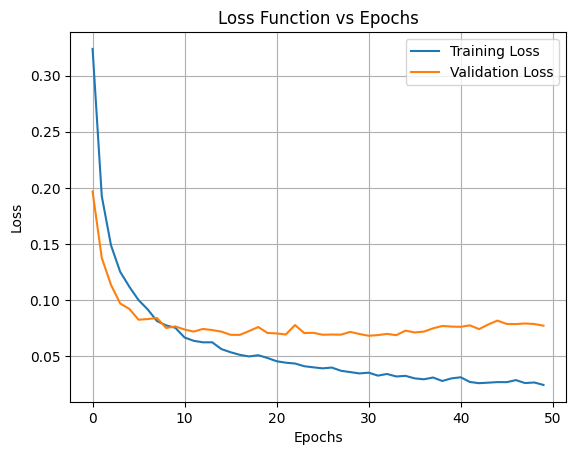

Final training accuracy: 0.9916
Final dev accuracy: 0.9815

Final training error: 0.84 %
Final dev error: 1.85 %


In [9]:
# Hyperparameters 'best' (b) with dropout

lr_b = 0.0001
batch_b = 32
epoch_b = 50
units_b = 256
activation_b = 'tanh'
optimizer_b = 'rmsprop'

# Function to create and compile model
def create_model(learning_rate, batch_size, hidden_units, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dropout(0.3),  # Add Dropout layer with a dropout rate of 0.3
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Create and train the model
model = create_model(lr_b, batch_b, units_b, activation_b, optimizer_b)

history = model.fit(x_train, y_train, 
                    epochs=epoch_b, 
                    batch_size=batch_b, 
                    validation_data=(x_test, y_test), 
                    verbose=0)

# Evaluate model performance
training_error = (1 - history.history['accuracy'][-1])
val_accuracy = history.history['val_accuracy'][-1]
dev_error = 1 - val_accuracy

# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Print metrics
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"\nFinal training error: {training_error*100:.2f} %")
print(f"Final dev error: {dev_error*100:.2f} %")


We note a slight increase in the dev error compared to the best case without dropout, but also a smaller variance, suggesting that regularization can indeed help the model generalize better to unseen data. Let us thus try to vary the dropout rate to examine whether there are choices of the parameter that can lead to a decreased variance while retaining, and possibly improving, the large accuracy on the dev set. We vary the dropout rate between 0.1 and 0.6 in steps of 0.1

Testing Dropout Rate: 0.1
Dropout Rate: 0.1
Final training accuracy: 0.9991
Final dev accuracy: 0.9815
Training error: 0.09%
Validation error: 1.85%


Testing Dropout Rate: 0.2
Dropout Rate: 0.2
Final training accuracy: 0.9962
Final dev accuracy: 0.9813
Training error: 0.38%
Validation error: 1.87%


Testing Dropout Rate: 0.30000000000000004
Dropout Rate: 0.30000000000000004
Final training accuracy: 0.9924
Final dev accuracy: 0.9816
Training error: 0.76%
Validation error: 1.84%


Testing Dropout Rate: 0.4
Dropout Rate: 0.4
Final training accuracy: 0.9866
Final dev accuracy: 0.9805
Training error: 1.34%
Validation error: 1.95%


Testing Dropout Rate: 0.5
Dropout Rate: 0.5
Final training accuracy: 0.9789
Final dev accuracy: 0.9793
Training error: 2.11%
Validation error: 2.07%




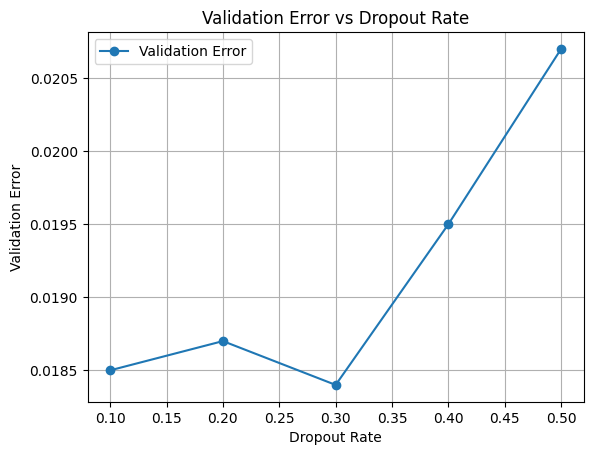

In [10]:
# Hyperparameters 'best' (b) with dropout
lr_b = 0.0001
batch_b = 32
epoch_b = 50
units_b = 256
activation_b = 'tanh'
optimizer_b = 'rmsprop'


# Function to create and compile model
def create_model_dropout(learning_rate, batch_size, hidden_units, dropout_rate, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dropout(dropout_rate),  # Add Dropout layer with a dropout rate of 0.3
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


# Store results
dropout_rates = np.arange(0.1, 0.6, 0.1)  # Dropout rates to test
val_errors = []  # Store validation errors
training_errors = []  # Store training errors


for drop_rate in dropout_rates:
    # Create and train the model
    print(f"Testing Dropout Rate: {drop_rate}")
    model = create_model_dropout(lr_b, batch_b, units_b, drop_rate, activation_b, optimizer_b)
    
    history = model.fit(x_train, y_train, 
                        epochs=epoch_b, 
                        batch_size=batch_b, 
                        validation_data=(x_test, y_test), 
                        verbose=0)
    
    # Evaluate model performance
    training_error = (1 - history.history['accuracy'][-1])
    val_accuracy = history.history['val_accuracy'][-1]
    dev_error = 1 - val_accuracy


    # Store results
    training_errors.append(training_error)
    val_errors.append(dev_error)
    
    # Print metrics
    print(f"Dropout Rate: {drop_rate}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Training error: {training_error*100:.2f}%")
    print(f"Validation error: {dev_error*100:.2f}%")
    print("\n")

# Plot validation error vs dropout rate
plt.plot(dropout_rates, val_errors, label='Validation Error', marker='o')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Error')
plt.title('Validation Error vs Dropout Rate')
plt.legend()
plt.grid()
plt.show()

The **lowest validation error** is achieved with a **dropout rate of 0.3**, along with a **notably reduced variance**. This suggests it may be valuable to **explore dropout rates around 0.3** more closely.

Compared to the best-performing benchmark model without dropout, this model exhibits:
- **Lower variance**, indicating better generalization
- A **slightly higher validation error**, likely due to the random "turning off" of units during training

To address this trade-off, we propose **increasing the number of hidden units** to compensate for the reduced capacity caused by dropout. This could allow the model to retain its generalization benefits while recovering some of the performance lost due to dropped units.

Therefore, in the code below, we explore **both strategies simultaneously**:
- Varying the **dropout rate** between **0.25 and 0.35** (in steps of 0.01)
- Testing with **256** and **512 hidden units** in the dense layer



Evaluating model with 256 hidden units:

Testing Dropout Rate: 0.25
Final training accuracy: 0.9941
Final dev accuracy: 0.9817
Training error: 0.59%
Validation error: 1.83%

Testing Dropout Rate: 0.26
Final training accuracy: 0.9936
Final dev accuracy: 0.9804
Training error: 0.64%
Validation error: 1.96%

Testing Dropout Rate: 0.27
Final training accuracy: 0.9934
Final dev accuracy: 0.9818
Training error: 0.66%
Validation error: 1.82%

Testing Dropout Rate: 0.28
Final training accuracy: 0.9925
Final dev accuracy: 0.9826
Training error: 0.75%
Validation error: 1.74%

Testing Dropout Rate: 0.29000000000000004
Final training accuracy: 0.9926
Final dev accuracy: 0.9814
Training error: 0.74%
Validation error: 1.86%

Testing Dropout Rate: 0.30000000000000004
Final training accuracy: 0.9921
Final dev accuracy: 0.9815
Training error: 0.79%
Validation error: 1.85%

Testing Dropout Rate: 0.31000000000000005
Final training accuracy: 0.9910
Final dev accuracy: 0.9826
Training error: 0.90%
Validat

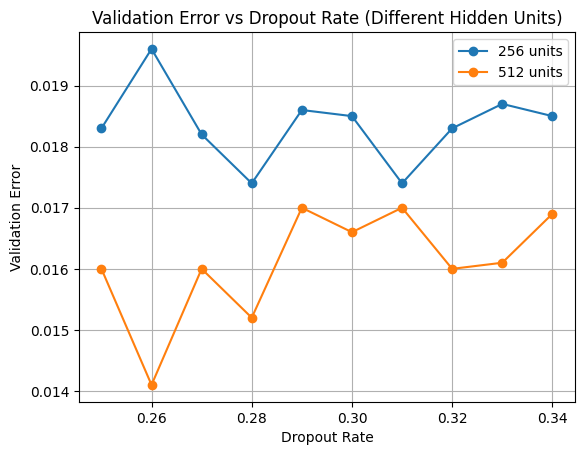

In [11]:
# Hyperparameters 'best' (b) with dropout
lr_b = 0.0001
batch_b = 32
epoch_b = 50
activation_b = 'tanh'
optimizer_b = 'rmsprop'

# Function to create and compile model
def create_model_dropout(learning_rate, batch_size, hidden_units, dropout_rate, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Dropout rates and hidden unit sizes to test
dropout_rates = np.arange(0.25, 0.35, 0.01)
hidden_units_list = [256, 512]

# Store results
results = []

for units_b in hidden_units_list:
    val_errors = []
    training_errors = []
    
    print(f"\nEvaluating model with {units_b} hidden units:\n")
    
    for drop_rate in dropout_rates:
        print(f"Testing Dropout Rate: {drop_rate}")
        
        model = create_model_dropout(lr_b, batch_b, units_b, drop_rate, activation_b, optimizer_b)
        
        history = model.fit(x_train, y_train, 
                            epochs=epoch_b, 
                            batch_size=batch_b, 
                            validation_data=(x_test, y_test), 
                            verbose=0)
        
        training_accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        training_error = 1 - training_accuracy
        dev_error = 1 - val_accuracy
        
        val_errors.append(dev_error)
        training_errors.append(training_error)
        
        print(f"Final training accuracy: {training_accuracy:.4f}")
        print(f"Final dev accuracy: {val_accuracy:.4f}")
        print(f"Training error: {training_error*100:.2f}%")
        print(f"Validation error: {dev_error*100:.2f}%\n")
    
    results.append({
        'hidden_units': units_b,
        'dropout_rates': dropout_rates.copy(),
        'val_errors': val_errors.copy(),
        'training_errors': training_errors.copy()
    })

# Plot results
for result in results:
    plt.plot(result['dropout_rates'], result['val_errors'], marker='o', label=f"{result['hidden_units']} units")

plt.xlabel('Dropout Rate')
plt.ylabel('Validation Error')
plt.title('Validation Error vs Dropout Rate (Different Hidden Units)')
plt.legend()
plt.grid()
plt.show()

### Final Evaluation and Best Model Summary

As shown in the final plot, the model with **512 hidden units** achieves a significantly **higher accuracy** than the one with 256 units, while maintaining a **comparable variance** in the range of **1.00–1.20%**. 

The most accurate model identified in this search has the following hyperparameters:

- Hidden units: `512`
- Learning rate: `0.0001`  
- Batch size: `32`  
- Epochs: `50`  
- Activation: `tanh`  
- Optimizer: `rmsprop`  

This model achieves a **dev error: 1.41%** and a **variance: 1.14%**, representing a clear improvement in both performance and generalization. This yields a substantial improvement compared to the initial benchmark model, which had **dev error: 2.33** and **variance: 2.01%**.

This highlights the importance of both the **choice of hyperparameters** and of **regularization**, in order to achieve an **accurate model** which **generalizes well** to unseen data.

## CNN for MNIST Digit Recognition

We now move on to implement a **Convolutional Neural Network (CNN)** for the same MNIST digit classification task.

As with the fully connected neural network (FCNN), we begin with a **benchmark CNN model** before performing a **randomized hyperparameter search** and, if needed, adding **regularization**.

Following standard practice in image recognition, the architecture consists of:
- Two sequences of a **convolutional layer** followed by a **max-pooling layer**
- A **flattening layer**
- Two **dense (fully connected) layers**
- A final **softmax output layer** with 10 units (one for each digit class)

In this benchmark model:
- Each **convolutional layer** uses **ReLU activation** and a **3×3 filter** to extract local spatial features
- The **first convolutional layer** uses **32 filters**, and the **second** uses **64 filters**, enabling the network to learn increasingly complex patterns
- Each convolutional layer is followed by a **2×2 max-pooling layer** to reduce spatial dimensions and computational cost

After feature extraction:
- The output is **flattened** and passed through a dense layer with **128 neurons** and **ReLU activation**
- The final layer is a **softmax-activated dense layer** with 10 neurons, corresponding to the 10 digit classes in MNIST

The model is trained using the **Adam optimizer** (adaptive learning rate) and the **sparse categorical cross-entropy** loss function. Training is performed over **10 epochs**, with validation performance monitored throughout.


In [9]:
# Reshape input data for CNN and normalize pixels
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Pixel range: 0.0 to 0.003921569
Label sample: [5 0 4 1 9]
Label shape: (60000,)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 - 38s - 20ms/step - accuracy: 0.7706 - loss: 0.7074 - val_accuracy: 0.9188 - val_loss: 0.2683
Epoch 2/10
1875/1875 - 38s - 20ms/step - accuracy: 0.9346 - loss: 0.2164 - val_accuracy: 0.9561 - val_loss: 0.1487
Epoch 3/10
1875/1875 - 37s - 20ms/step - accuracy: 0.9564 - loss: 0.1443 - val_accuracy: 0.9650 - val_loss: 0.1111
Epoch 4/10
1875/1875 - 37s - 20ms/step - accuracy: 0.9645 - loss: 0.1141 - val_accuracy: 0.9698 - val_loss: 0.0919
Epoch 5/10
1875/1875 - 38s - 20ms/step - accuracy: 0.9698 - loss: 0.0961 - val_accuracy: 0.9740 - val_loss: 0.0797
Epoch 6/10
1875/1875 - 37s - 20ms/step - accuracy: 0.9745 - loss: 0.0833 - val_accuracy: 0.9774 - val_loss: 0.0708
Epoch 7/10
1875/1875 - 38s - 20ms/step - accuracy: 0.9778 - loss: 0.0734 - val_accuracy: 0.9804 - val_loss: 0.0633
Epoch 8/10
1875/1875 - 38s - 20ms/step - accuracy: 0.9800 - loss: 0.0656 - val_accuracy: 0.9820 - val_loss: 0.0581
Epoch 9/10
1875/1875 - 38s - 20ms/step - accuracy: 0.9822 - loss: 0.0594 - val_a

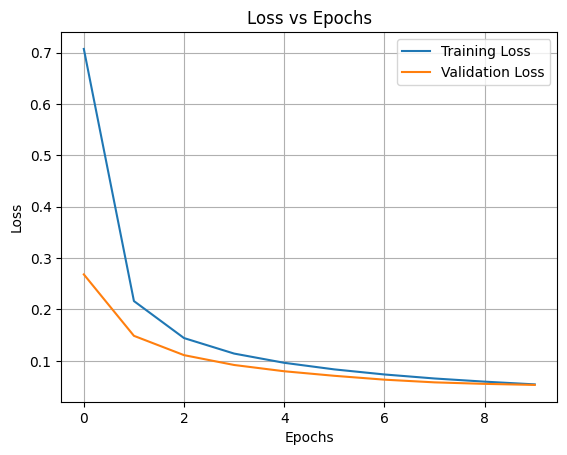


Final training accuracy: 0.9838
Final validation (dev) accuracy: 0.9839
Final training error: 1.62%
Final dev error: 1.61%
Test set accuracy (from evaluate): 0.9839
Training time: 377.29 seconds


In [19]:
# Benchmark Convolutional Neural Network (CNN)

# Check input range
print("Pixel range:", x_train.min(), "to", x_train.max())

# Check label format
print("Label sample:", y_train[:5])
print("Label shape:", y_train.shape)

# Define the CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for MNIST
])

# Show model summary
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Start training timer
start_time = time.time()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=2
)

# End timer
end_time = time.time()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

training_error = 1 - train_accuracy
dev_error = 1 - val_accuracy

print(f"\nFinal training accuracy: {train_accuracy:.4f}")
print(f"Final validation (dev) accuracy: {val_accuracy:.4f}")
print(f"Final training error: {training_error * 100:.2f}%")
print(f"Final dev error: {dev_error * 100:.2f}%")
print(f"Test set accuracy (from evaluate): {test_accuracy:.4f}")
print(f"Training time: {end_time - start_time:.2f} seconds")

This benchmark CNN model yields the following results:

- **Final training accuracy**: 98.38%  
- **Final validation (dev) accuracy**: 98.39%  
- **Final training error**: 1.62%  
- **Final dev error**: 1.61%

As a **semi-random, unoptimized benchmark**, this model already outperforms the initial **FCNN benchmark** (which had a dev error of **2.33%**) and shows **virtually no overfitting**. In fact, the dev accuracy is comparable to the FCNN benchmark with the best choice of hyparparameters, but for a fraction of the computational time!

---

We now move on to perform a **randomized hyperparameter search**. Unlike the **grid search** used for the FCNN (chosen for pedagogical clarity), this approach allows us to explore a **wider range of configurations** while keeping computational cost manageable.

#### Hyperparameters to Tune:
- **Number of filters** in each convolutional layer: 32, 64, 96, 128  
- **Kernel sizes**: (3×3) and (5×5)  
- **Optimizers**: `adam`, `sgd`

The search will be managed using the **Hyperband** algorithm, which efficiently allocates resources by:
- **Pruning underperforming models early**
- **Focusing training on the most promising configurations**

---

### Expected Outcome

We anticipate this search to:
- Yield **higher validation accuracy** than the benchmark CNN
- Identify an optimal balance between **model complexity** and **generalization**
- Allow us to assess whether the added complexity justifies the improvement, by tracking total training time

This exploration will provide deeper insights into the trade-offs involved in CNN architecture design for digit classification.


In [ ]:
# Hyperparameter search 

# Define the model-building function
def build_model(hp):
    model = models.Sequential()
    
    # First convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Int('filters1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size1', values=[3, 5]),
        activation='relu',
        input_shape=(28, 28, 1)
    ))
    model.add(layers.MaxPooling2D(2, 2))

    # Second convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Int('filters2', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size2', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Flatten())
    
    # Dense layer
    model.add(layers.Dense(128, activation='relu'))

    # Output layer
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Delete previous tuning directory if it exists
shutil.rmtree('my_dir/cnn_mnist_tuning', ignore_errors=True)

# Set up the tuner with Hyperband strategy
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='cnn_mnist_tuning'
)

# Start the timer
start_time = time.time()

# Run the search
tuner.search(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

# Stop the timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTime taken for hyperparameter search: {elapsed_time:.2f} seconds")

# Get the top 3 models and print their info
top_n = 3
top_models = tuner.get_best_models(num_models=top_n)
top_hp = tuner.get_best_hyperparameters(num_trials=top_n)

print("\nTop 3 models:")
for i in range(top_n):
    val_acc = top_models[i].evaluate(x_test, y_test, verbose=0)[1]
    print(f"\nModel {i+1}:")
    print(f"  Validation accuracy: {val_acc:.4f}")
    print(f"  Hyperparameters: {top_hp[i].values}")

# Save only the best model
top_models[0].save("best_model.keras")
print("\nBest model saved as 'best_model.keras'")

Trial 84 Complete [00h 13m 16s]
val_accuracy: 0.987500011920929

Best val_accuracy So Far: 0.9897000193595886
Total elapsed time: 02h 45m 15s

Search: Running Trial #85

Value             |Best Value So Far |Hyperparameter
32                |96                |filters1
3                 |5                 |kernel_size1
64                |32                |filters2
3                 |5                 |kernel_size2
sgd               |adam              |optimizer
30                |30                |tuner/epochs
10                |10                |tuner/initial_epoch
1                 |3                 |tuner/bracket
1                 |3                 |tuner/round
0074              |0046              |tuner/trial_id

Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.1127 - loss: 2.3012 - val_accuracy: 0.1135 - val_loss: 2.3008
Epoch 12/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.1127 - loss: 2.3012 - val_accuracy: 0.1135 - val_loss: 2.3008
Ep

In [11]:
# Load the best saved model
best_model = load_model("best_model.keras")

# Print model summary
print("Best Model Architecture:\n")
best_model.summary()

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
test_error = 1 - test_accuracy

# Evaluate on training set
train_loss, train_accuracy = best_model.evaluate(x_train, y_train, verbose=0)
train_error = 1 - train_accuracy

# Print performance
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Error: {test_error * 100:.2f}%")

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Training Error: {train_error * 100:.2f}%")


Best Model Architecture:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,100,768 (4.20 MB)

 Trainable params: 366,922 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 733,846 (2.80 MB)


Test Accuracy: 0.9893
Test Error: 1.07%

Training Accuracy: 0.9987
Training Error: 0.13%


### Final Comparison and Conclusion

The best CNN model achieves a **dev error of 1.07%** with a **variance of 0.94%**, outperforming the best FCNN model, which achieved a **dev error of 1.41%** and a **variance of 1.14%**.

This confirms that convolutional architectures are significantly more effective than fully connected networks for image recognition tasks like MNIST, both in terms of accuracy and generalization.

---

### Next Steps

Potential future improvements could include:
- Incorporating **regularization techniques** such as dropout or batch normalization
- Exploring **pretrained embeddings** or **transfer learning** for larger image datasets
- Applying this pipeline to more complex image classification tasks beyond MNIST
